In [49]:
import librosa
from librosa import feature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [82]:
def extract_features(file):

    # check if normal or abnormal
    if 'abnormal' in file:
        operation=1
    else:
        operation=0
    # loading the file, getting y and sr (sample rate)

    y, sr = librosa.load(file)

    # Getting S and phase

    S, phase = librosa.magphase(librosa.stft(y=y))

    # Features for the DataFrame
# chroma features have pitch which is probably not usefull
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr))

    chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr))
# to do
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_min = np.min(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_max = np.max(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_sum = librosa.feature.melspectrogram(y=y, sr=sr, S=S).sum()
    melspectrogram_corr= np.mean(np.corrcoef(librosa.feature.melspectrogram(y=y, sr=sr, S=S)))
    melspectrogram_std= np.std(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
# to check This feature is one of the most important method to extract a feature of an audio signal and is 
#used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal 
#are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral 
#envelope.
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr))
#rms when plotted similarities with melspectorgram
#normal rms mean higher than abnormal?
    rms = np.mean(librosa.feature.rms(y=y, S=S))
#spectral centroid computes weighted mean of the frequencies in the sound
#plot is line on melspectogram
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, S=S))
#Bandwidth(blue zone) is the difference between the upper and lower frequencies in a continuous band of frequencies
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, S=S))
#needs further investigation, but makes continous data discrete in bins
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, S=S))
#Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to
#being tone-like 1. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. 
#It is often converted to decibel.
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y, S=S))
#The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at 
#least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and 
#he bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent 
#to a value close to 1 (or 0).
#rolloff with rolloff coefficient 0.01 seems to be the same for (ab)normal
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, S=S))
#Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram
    poly_features = np.mean(librosa.feature.poly_features(y=y, sr=sr, S=S))
#probably chroma
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
#normal has higher zero crossing rate?
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
#divide in frequency bands could give more information bout difference normal and abnormal (BPM)
    #tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                       #    hop_length=hop_length)[0]
    # putting them into a dataframe
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    return pd.DataFrame({ 'melspectrogram' : [melspectrogram],'melspectrogram_min':[melspectrogram_min],
                             'melspectrogram_max':[melspectrogram_max], 'melspectrogram_sum':[melspectrogram_sum],
                             'melspectrogram_corr':[melspectrogram_corr] ,'melspectrogram_std':[melspectrogram_std] ,
                             'mfcc' : [mfcc], 'rms' : [rms],
                            'spectral_centroid' : [spectral_centroid], 'spectral_bandwidth' : [spectral_bandwidth],
                            'spectral_contrast' : [spectral_contrast], 'spectral_flatness ' : [spectral_flatness],
                            'spectral_rolloff' : [spectral_rolloff], 
                            'zero_crossing_rate' : [zero_crossing_rate],"mean harm": np.mean(y_harmonic),
                            "mean perc": [np.mean(y_percussive)],"max harm":[np.max(y_harmonic)],"max perc": [np.max(y_percussive)],
                             "min harm":[np.min(y_harmonic)], "min perc":[np.min(y_percussive)], 'normal(0)/abnormal(1)':[operation]})

In [83]:
import os
import sys
import time
# start measuring excecution time
start_time = time.time()
#create empty list that will be filled with pathnames
#find paths normal wav files
list_normal_6 = []
num=[0,2,4,6]
for i in num:
    directory_normal_6 = f"/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_0{i}/normal/"
    for filename in os.listdir(directory_normal_6):
        file = f"{directory_normal_6}{filename}"
        list_normal_6.append(file)
list_normal_6.sort()
#find paths abnormal wav files
list_abnormal_6 = []
num=[0,2,4,6]
for i in num:
    directory_abnormal_6 = f"/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_0{i}/abnormal/"
    for filename in os.listdir(directory_abnormal_6):
        file = f"{directory_abnormal_6}{filename}"
        list_abnormal_6.append(file)
list_abnormal_6.sort()
#add normal to df
for wav_file in list_normal_6:
    df = extract_features(wav_file)
    if wav_file == list_normal_6[0]:
        df.to_csv('Librosa_features.csv')
    else:
        df.to_csv('Librosa_features.csv', mode='a', header=False)
#add abnormal to df
for wav_file in list_abnormal_6:
    df = extract_features(wav_file)
    df.to_csv('Librosa_features.csv', mode='a', header=False) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 4516.273422718048 seconds ---


In [84]:
list_normal_6

['/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000000.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000001.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000002.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000003.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000004.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000005.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000006.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000007.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000008.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/00000009.wav',
 '/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00

In [85]:
valve=pd.read_csv('/home/regis/Desktop/Sound Project/Codit-project-main/Librosa_features.csv')

In [86]:
valve.head()

,Unnamed: 0,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,...,0.000852,2847.104130,0.060725,-3.781356e-07,4.012865e-07,0.006918,0.070441,-0.006861,-0.060939,0
1,0,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,...,0.001012,3777.878084,0.094482,-1.201143e-07,-3.884470e-07,0.006952,0.070928,-0.006763,-0.060128,0
2,0,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,...,0.000950,3394.926803,0.094802,-3.535212e-07,-4.008645e-07,0.007342,0.070832,-0.007282,-0.060499,0
3,0,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,...,0.000681,3035.257362,0.071383,-1.655043e-09,-1.397088e-07,0.006073,0.073961,-0.005455,-0.060447,0
4,0,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,...,0.000508,2481.789092,0.053385,-7.166033e-07,1.267004e-07,0.006912,0.070822,-0.006740,-0.063913,0


In [87]:
valve.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [88]:
valve.columns

Index(['melspectrogram', 'melspectrogram_min', 'melspectrogram_max',
       'melspectrogram_sum', 'melspectrogram_corr', 'melspectrogram_std',
       'mfcc', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'spectral_contrast', 'spectral_flatness ', 'spectral_rolloff',
       'zero_crossing_rate', 'mean harm', 'mean perc', 'max harm', 'max perc',
       'min harm', 'min perc', 'normal(0)/abnormal(1)'],
      dtype='object')

In [89]:
valve.head()

,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,spectral_bandwidth,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,1635.526256,...,0.000852,2847.104130,0.060725,-3.781356e-07,4.012865e-07,0.006918,0.070441,-0.006861,-0.060939,0
1,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,1767.165689,...,0.001012,3777.878084,0.094482,-1.201143e-07,-3.884470e-07,0.006952,0.070928,-0.006763,-0.060128,0
2,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,1784.159467,...,0.000950,3394.926803,0.094802,-3.535212e-07,-4.008645e-07,0.007342,0.070832,-0.007282,-0.060499,0
3,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,1585.731245,...,0.000681,3035.257362,0.071383,-1.655043e-09,-1.397088e-07,0.006073,0.073961,-0.005455,-0.060447,0
4,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,1510.835471,...,0.000508,2481.789092,0.053385,-7.166033e-07,1.267004e-07,0.006912,0.070822,-0.006740,-0.063913,0


In [90]:
valve.dtypes

melspectrogram           float64
melspectrogram_min       float64
melspectrogram_max       float64
melspectrogram_sum       float64
melspectrogram_corr      float64
melspectrogram_std       float64
mfcc                     float64
rms                      float64
spectral_centroid        float64
spectral_bandwidth       float64
spectral_contrast        float64
spectral_flatness        float64
spectral_rolloff         float64
zero_crossing_rate       float64
mean harm                float64
mean perc                float64
max harm                 float64
max perc                 float64
min harm                 float64
min perc                 float64
normal(0)/abnormal(1)      int64
dtype: object

In [91]:
valve.shape

(4170, 21)

Decision trees are very easy as compared to the random forest. A decision tree combines some decisions, whereas a random forest combines several decision trees. Thus, it is a long process, yet slow.

Whereas, a decision tree is fast and operates easily on large data sets, especially the linear one. The random forest model needs rigorous training. When you are trying to put up a project, you might need more than one model. Thus, a large number of random forests, more the time. 

It depends on your requirements. If you have less time to work on a model, you are bound to choose a decision tree. However, stability and reliable predictions are in the basket of random forests. 

## Random Forest

In [92]:
y=valve['normal(0)/abnormal(1)'].values
x=valve.drop(columns=['normal(0)/abnormal(1)'], axis=1)

In [93]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [94]:
x.head()

,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc
0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,1635.526256,21.795884,0.000852,2847.104130,0.060725,-3.781356e-07,4.012865e-07,0.006918,0.070441,-0.006861,-0.060939
1,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,1767.165689,21.547031,0.001012,3777.878084,0.094482,-1.201143e-07,-3.884470e-07,0.006952,0.070928,-0.006763,-0.060128
2,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,1784.159467,23.085971,0.000950,3394.926803,0.094802,-3.535212e-07,-4.008645e-07,0.007342,0.070832,-0.007282,-0.060499
3,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,1585.731245,21.018282,0.000681,3035.257362,0.071383,-1.655043e-09,-1.397088e-07,0.006073,0.073961,-0.005455,-0.060447
4,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,1510.835471,21.688802,0.000508,2481.789092,0.053385,-7.166033e-07,1.267004e-07,0.006912,0.070822,-0.006740,-0.063913


In [95]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [96]:
xTrain.shape

(3336, 20)

should we standardise or normalize or nothing?

Thanks for the clarification by commenting. Tree-based models do not care about the absolute value that a feature takes. They only care about the order of the values. Hence, normalization is used mainly in linear models/knn/neural networks because they're affected by absolute values taken by features.

You don't need to normalize/standardize.

In [97]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

check what metrics most important

In [115]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[740   5]
 [ 34  55]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       745
           1       0.92      0.62      0.74        89

    accuracy                           0.95       834
   macro avg       0.94      0.81      0.86       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9532374100719424


In [118]:
834-(834*0.9532374100719424)

39.0

In [100]:
valve.shape

(4170, 21)

In [101]:
y_pred.shape

(834,)

In [103]:
yTest.shape

(834,)

In [104]:
xTest.shape

(834, 20)

In [105]:
xTest.head()

,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc
1950,0.007732,8.076448e-10,0.240814,426.550903,0.457082,0.012411,-14.734518,0.003286,1635.399730,1842.423772,21.385414,0.000763,3744.479136,0.069911,2.848271e-08,8.708768e-07,0.007074,0.076012,-0.006702,-0.045171
3435,0.006734,7.213018e-10,0.287798,371.491241,0.517714,0.011847,-14.923219,0.003148,1684.726429,1876.092358,23.203076,0.000743,3614.780307,0.080222,3.841903e-07,5.377511e-07,0.009481,0.056683,-0.008437,-0.045473
1926,0.006793,7.308973e-10,0.228192,374.743134,0.512241,0.012651,-14.380542,0.003194,1443.349190,1803.653355,21.803495,0.000538,3164.156814,0.053194,1.425133e-06,9.915567e-07,0.007672,0.074927,-0.007106,-0.043955
1784,0.007382,7.882814e-10,0.229776,407.270752,0.489502,0.012443,-14.083639,0.003215,1501.802700,1778.906504,21.217145,0.000651,3359.254629,0.060423,-1.248084e-06,1.116918e-06,0.006814,0.072664,-0.006417,-0.047220
3970,0.005740,6.731675e-10,0.255278,316.685425,0.493568,0.012284,-14.300553,0.003079,1146.125075,1684.589994,22.052215,0.000326,2417.589171,0.037337,-6.705058e-07,-1.437777e-06,0.007507,0.068844,-0.008115,-0.042379


In [107]:
yTest

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [108]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [113]:
count=0
for i in range(len(yTest)):
    if yTest[i]!=y_pred[i]:
        count = count + 1
print(count)

39


## Feature dropping

In [155]:
x_columns=list(x.columns)

In [156]:
x_columns

['melspectrogram',
 'melspectrogram_min',
 'melspectrogram_max',
 'melspectrogram_sum',
 'melspectrogram_corr',
 'melspectrogram_std',
 'mfcc',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'spectral_contrast',
 'spectral_flatness ',
 'spectral_rolloff',
 'zero_crossing_rate',
 'mean harm',
 'mean perc',
 'max harm',
 'max perc',
 'min harm',
 'min perc']

Feature: 0,	 Name: melspectrogram, 	 Score: 3.54271
Feature: 1,	 Name: melspectrogram_min, 	 Score: 9.80207
Feature: 2,	 Name: melspectrogram_max, 	 Score: 3.78305
Feature: 3,	 Name: melspectrogram_sum, 	 Score: 9.92060
Feature: 4,	 Name: melspectrogram_corr, 	 Score: 5.11850
Feature: 5,	 Name: melspectrogram_std, 	 Score: 2.93117
Feature: 6,	 Name: mfcc, 	 Score: 4.72874
Feature: 7,	 Name: rms, 	 Score: 3.04573
Feature: 8,	 Name: spectral_centroid, 	 Score: 2.25840
Feature: 9,	 Name: spectral_bandwidth, 	 Score: 2.45681
Feature: 10,	 Name: spectral_contrast, 	 Score: 2.91034
Feature: 11,	 Name: spectral_flatness , 	 Score: 2.99187
Feature: 12,	 Name: spectral_rolloff, 	 Score: 26.97188
Feature: 13,	 Name: zero_crossing_rate, 	 Score: 2.74773
Feature: 14,	 Name: mean harm, 	 Score: 16.79040


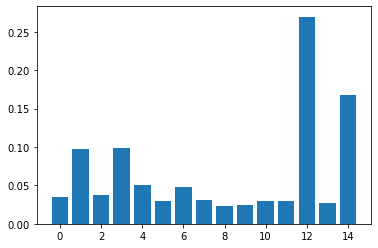

In [157]:
# get importance
importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

drop columns with values below 2%

In [158]:
x_reduced=x.drop(columns=['melspectrogram_min','spectral_centroid','spectral_rolloff','mean harm','mean perc'], axis=1)

In [159]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x_reduced, y, test_size = 0.2, random_state = 42)

In [160]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

In [161]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[739   6]
 [ 32  57]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       745
           1       0.90      0.64      0.75        89

    accuracy                           0.95       834
   macro avg       0.93      0.82      0.86       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9544364508393285


Feature: 0,	 Name: melspectrogram, 	 Score: 3.54271
Feature: 1,	 Name: melspectrogram_min, 	 Score: 9.80207
Feature: 2,	 Name: melspectrogram_max, 	 Score: 3.78305
Feature: 3,	 Name: melspectrogram_sum, 	 Score: 9.92060
Feature: 4,	 Name: melspectrogram_corr, 	 Score: 5.11850
Feature: 5,	 Name: melspectrogram_std, 	 Score: 2.93117
Feature: 6,	 Name: mfcc, 	 Score: 4.72874
Feature: 7,	 Name: rms, 	 Score: 3.04573
Feature: 8,	 Name: spectral_centroid, 	 Score: 2.25840
Feature: 9,	 Name: spectral_bandwidth, 	 Score: 2.45681
Feature: 10,	 Name: spectral_contrast, 	 Score: 2.91034
Feature: 11,	 Name: spectral_flatness , 	 Score: 2.99187
Feature: 12,	 Name: spectral_rolloff, 	 Score: 26.97188
Feature: 13,	 Name: zero_crossing_rate, 	 Score: 2.74773
Feature: 14,	 Name: mean harm, 	 Score: 16.79040


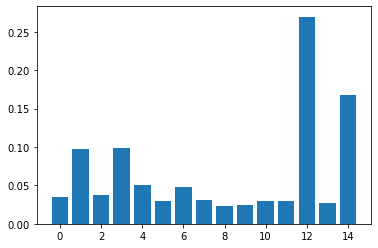

In [162]:
# get importance
importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

when dropping: 0.9544364508393285 without:0.9532374100719424 / 0.9532374100719424==> improved

In [170]:
x_reducedd=x.drop(columns=['melspectrogram_min','spectral_centroid','spectral_rolloff','mean harm','mean perc','zero_crossing_rate','melspectrogram','melspectrogram_sum','melspectrogram_std','mfcc','rms','spectral_bandwidth','spectral_contrast','spectral_flatness ','max harm','min harm',], axis=1)

In [171]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x_reducedd, y, test_size = 0.2, random_state = 42)

In [172]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

In [173]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[736   9]
 [ 30  59]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       745
           1       0.87      0.66      0.75        89

    accuracy                           0.95       834
   macro avg       0.91      0.83      0.86       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9532374100719424


Feature: 0,	 Name: melspectrogram, 	 Score: 21.02548
Feature: 1,	 Name: melspectrogram_min, 	 Score: 18.82096
Feature: 2,	 Name: melspectrogram_max, 	 Score: 39.66551
Feature: 3,	 Name: melspectrogram_sum, 	 Score: 20.48805


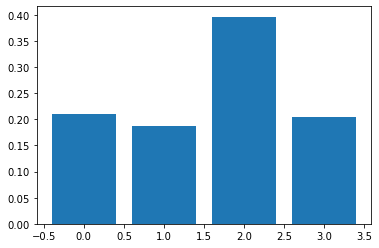

In [174]:
# get importance
importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## to reuse in necessary

In [20]:
def extract_features(file):

    # check if normal or abnormal
    if 'abnormal' in file:
        operation=1
    else:
        operation=0
    # loading the file, getting y and sr (sample rate)

    y, sr = librosa.load(file)

    # Getting S and phase

    S, phase = librosa.magphase(librosa.stft(y=y))

    # Features for the DataFrame
# chroma features have pitch which is probably not usefull
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr))

    chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr))
# to do
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
# to check This feature is one of the most important method to extract a feature of an audio signal and is 
#used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal 
#are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral 
#envelope.

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr))
#rms when plotted similarities with melspectorgram
#normal rms mean higher than abnormal?
    rms = np.mean(librosa.feature.rms(y=y, S=S))
#spectral centroid computes weighted mean of the frequencies in the sound
#plot is line on melspectogram
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, S=S))
#Bandwidth(blue zone) is the difference between the upper and lower frequencies in a continuous band of frequencies
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, S=S))
#needs further investigation, but makes continous data discrete in bins
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, S=S))
#Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to
#being tone-like 1. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. 
#It is often converted to decibel.
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y, S=S))
#The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at 
#least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and 
#he bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent 
#to a value close to 1 (or 0).
#rolloff with rolloff coefficient 0.01 seems to be the same for (ab)normal
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, S=S))
#Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram
    poly_features = np.mean(librosa.feature.poly_features(y=y, sr=sr, S=S))
#probably chroma
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
#normal has higher zero crossing rate?
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
#divide in frequency bands could give more information bout difference normal and abnormal (BPM)
    #tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                       #    hop_length=hop_length)[0]
    # putting them into a dataframe
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    return pd.DataFrame({'chroma_stft': [chroma_stft], 'chroma_cqt': [chroma_cqt], 'chroma_cens' : [chroma_cens], 
                            'melspectrogram' : [melspectrogram], 'mfcc' : [mfcc], 'rms' : [rms],
                            'spectral_centroid' : [spectral_centroid], 'spectral_bandwidth' : [spectral_bandwidth],
                            'spectral_contrast' : [spectral_contrast], 'spectral_flatness ' : [spectral_flatness],
                            'spectral_rolloff' : [spectral_rolloff], 'poly_features' : [poly_features], 
                            'tonnetz' : [tonnetz], 'zero_crossing_rate' : [zero_crossing_rate],"mean harm": np.mean(y_harmonic),
                            "mean perc": [np.mean(y_percussive)],"max harm":[np.max(y_harmonic)],"max perc": [np.max(y_percussive)],
                             "min harm":[np.min(y_harmonic)], "min perc":[np.min(y_percussive)], 'normal(0)/abnormal(1)':[operation]})

In [ ]:
import os
import sys
import time
# start measuring excecution time
start_time = time.time()
#create empty list that will be filled with pathnames
#find paths normal wav files
list_normal_6 = []
directory_normal_6 = "/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/normal/"
for filename in os.listdir(directory_normal_6):
    file = f"{directory_normal_6}{filename}"
    list_normal_6.append(file)
list_normal_6.sort()
#find paths abnormal wav files
list_abnormal_6 = []
directory_abnormal_6 = "/home/regis/Desktop/Sound Project/files/valve/6_dB_valve/valve/id_00/abnormal/"
for filename in os.listdir(directory_abnormal_6):
    file = f"{directory_abnormal_6}{filename}"
    list_abnormal_6.append(file)
list_normal_6.sort()
#add normal to df
for wav_file in list_normal_6:
    df = extract_features(wav_file)
    if wav_file == list_normal_6[0]:
        df.to_csv('Librosa_features.csv')
    else:
        df.to_csv('Librosa_features.csv', mode='a', header=False)
#add abnormal to df
for wav_file in list_abnormal_6:
    df = extract_features(wav_file)
    df.to_csv('Librosa_features.csv', mode='a', header=False) 
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
xTrain = sc.fit_transform(xTrain)
xTest = sc.fit_transform(xTest)

In [1]:
import pandas as pd

In [28]:
df1 = pd.read_csv("Librosa_features_valve_-6dB.csv")
df2 = pd.read_csv("Librosa_features_valve_0dB.csv")
df3 = pd.read_csv("Librosa_features_valve_6dB.csv")

In [5]:
df1.head()

,Unnamed: 0,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0,0.022480,1.442308e-09,0.493685,1240.156494,0.432580,0.027328,-10.324082,0.008268,1737.292885,...,0.000629,3566.218188,0.098873,-2.914727e-07,-1.149451e-06,0.024765,0.104119,-0.025627,-0.085298,0
1,0,0.020149,2.410685e-09,0.497935,1111.591919,0.304895,0.034391,-7.917194,0.009365,1362.034893,...,0.000419,2937.083941,0.053674,1.012487e-06,2.031724e-06,0.030395,0.076841,-0.030091,-0.060521,0
2,0,0.018505,2.161935e-09,0.458983,1020.858337,0.296927,0.028953,-11.309975,0.008393,1672.072644,...,0.000424,3644.831866,0.084243,-7.028235e-08,-1.127828e-06,0.028087,0.073661,-0.029678,-0.070317,0
3,0,0.022684,2.500427e-09,0.366949,1251.411743,0.253426,0.034434,-8.453393,0.009657,1330.873320,...,0.000294,2854.123654,0.057706,9.979737e-08,7.113005e-07,0.023710,0.068743,-0.026346,-0.062864,0
4,0,0.018276,2.383335e-09,0.331989,1008.249695,0.298718,0.029644,-11.612918,0.008630,1547.006259,...,0.000318,3178.745434,0.074161,-1.004464e-06,-1.443682e-06,0.029470,0.086958,-0.028582,-0.074641,0


In [6]:
df2.head()

,Unnamed: 0,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0,0.010227,1.219319e-09,0.346582,564.221008,0.428454,0.017281,-13.152510,0.004923,1696.929323,...,0.000819,3667.389270,0.081875,-6.366340e-07,-4.054679e-07,0.015599,0.069808,-0.016116,-0.059696,0
1,0,0.010362,1.013630e-09,0.305407,571.659790,0.435997,0.016444,-13.552141,0.004817,1736.975565,...,0.000622,3785.047491,0.086604,-3.070700e-07,1.873772e-08,0.017073,0.069303,-0.017801,-0.057992,0
2,0,0.011956,1.306787e-09,0.175170,659.591431,0.390569,0.017997,-11.940767,0.005164,1277.822873,...,0.000429,2625.027360,0.056760,1.369169e-06,-7.680732e-07,0.013448,0.070701,-0.013480,-0.060841,0
3,0,0.010021,1.222154e-09,0.243078,552.858948,0.439885,0.017521,-13.513590,0.004995,1687.317374,...,0.000511,3834.084240,0.071126,3.107202e-07,-7.483548e-07,0.015373,0.073137,-0.015797,-0.058522,0
4,0,0.010402,1.244658e-09,0.219841,573.853516,0.466167,0.018425,-11.875802,0.005084,1215.123818,...,0.000313,2479.066216,0.052142,-7.228301e-07,2.679114e-06,0.014246,0.069213,-0.013761,-0.061982,0


In [7]:
df3.head()

,Unnamed: 0,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,...,0.000852,2847.104130,0.060725,-3.781356e-07,4.012865e-07,0.006918,0.070441,-0.006861,-0.060939,0
1,0,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,...,0.001012,3777.878084,0.094482,-1.201143e-07,-3.884470e-07,0.006952,0.070928,-0.006763,-0.060128,0
2,0,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,...,0.000950,3394.926803,0.094802,-3.535212e-07,-4.008645e-07,0.007342,0.070832,-0.007282,-0.060499,0
3,0,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,...,0.000681,3035.257362,0.071383,-1.655043e-09,-1.397088e-07,0.006073,0.073961,-0.005455,-0.060447,0
4,0,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,...,0.000508,2481.789092,0.053385,-7.166033e-07,1.267004e-07,0.006912,0.070822,-0.006740,-0.063913,0


In [23]:
df1.columns

Index(['Unnamed: 0_-6', 'melspectrogram_-6', 'melspectrogram_min_-6',
       'melspectrogram_max_-6', 'melspectrogram_sum_-6',
       'melspectrogram_corr_-6', 'melspectrogram_std_-6', 'mfcc_-6', 'rms_-6',
       'spectral_centroid_-6', 'spectral_bandwidth_-6', 'spectral_contrast_-6',
       'spectral_flatness _-6', 'spectral_rolloff_-6', 'zero_crossing_rate_-6',
       'mean harm_-6', 'mean perc_-6', 'max harm_-6', 'max perc_-6',
       'min harm_-6', 'min perc_-6', 'normal(0)/abnormal(1)_-6'],
      dtype='object')

In [4]:
import pandas as pd
from functools import reduce

In [5]:
df_min6dB = pd.read_csv("Librosa_features_valve_-6dB.csv")
df_0dB = pd.read_csv("Librosa_features_valve_0dB.csv")
df_6dB = pd.read_csv("Librosa_features_valve_6dB.csv")

In [6]:
def merge_pd(machine):
    df_6dB=pd.read_csv(f'Librosa_features_{machine}_6dB.csv')
    df_0dB=pd.read_csv(f'Librosa_features_{machine}_0dB.csv')
    df_min6dB=pd.read_csv(f'Librosa_features_{machine}_-6dB.csv')
    df_6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_0dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_min6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

    df_6dB.columns = [str(col) + '_6dB' for col in df_6dB.columns]
    df_0dB.columns = [str(col) + '_0dB' for col in df_0dB.columns]
    df_min6dB.columns = [str(col) + '_-6dB' for col in df_min6dB.columns]
    data_frames = [df_6dB, df_0dB, df_min6dB]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), data_frames)
    
    return df_merged

valve=merge_pd('valve')

valve.drop(columns=['normal(0)/abnormal(1)_6dB','normal(0)/abnormal(1)_0dB'],axis=1,inplace=True)
valve.rename(columns={'normal(0)/abnormal(1)_-6dB': 'normal(0)/abnormal(1)'}, inplace=True)

In [39]:
valve

,melspectrogram_6dB,melspectrogram_min_6dB,melspectrogram_max_6dB,melspectrogram_sum_6dB,melspectrogram_corr_6dB,melspectrogram_std_6dB,mfcc_6dB,rms_6dB,spectral_centroid_6dB,spectral_bandwidth_6dB,...,spectral_flatness _-6dB,spectral_rolloff_-6dB,zero_crossing_rate_-6dB,mean harm_-6dB,mean perc_-6dB,max harm_-6dB,max perc_-6dB,min harm_-6dB,min perc_-6dB,normal(0)/abnormal(1)
0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,1635.526256,...,0.000629,3566.218188,0.098873,-2.914727e-07,-1.149451e-06,0.024765,0.104119,-0.025627,-0.085298,0
1,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,1767.165689,...,0.000419,2937.083941,0.053674,1.012487e-06,2.031724e-06,0.030395,0.076841,-0.030091,-0.060521,0
2,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,1784.159467,...,0.000424,3644.831866,0.084243,-7.028235e-08,-1.127828e-06,0.028087,0.073661,-0.029678,-0.070317,0
3,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,1585.731245,...,0.000294,2854.123654,0.057706,9.979737e-08,7.113005e-07,0.023710,0.068743,-0.026346,-0.062864,0
4,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,1510.835471,...,0.000318,3178.745434,0.074161,-1.004464e-06,-1.443682e-06,0.029470,0.086958,-0.028582,-0.074641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,0.006145,5.907662e-10,0.254959,339.021027,0.452101,0.011963,-14.050967,0.003091,1390.284787,1667.558004,...,0.000368,3646.580502,0.081652,-5.208518e-07,-1.669572e-06,0.034763,0.050737,-0.029444,-0.034433,1
4166,0.006318,6.310800e-10,0.254083,348.544434,0.456175,0.011857,-13.962207,0.003026,1435.561016,1697.812631,...,0.000242,2850.176733,0.056757,1.597554e-07,-2.796939e-06,0.023207,0.040186,-0.021190,-0.036905,1
4167,0.005718,5.974771e-10,0.247175,315.462128,0.489549,0.010697,-15.545541,0.002731,1578.907756,1851.459591,...,0.000213,2594.775957,0.050464,1.254795e-06,2.009042e-06,0.024952,0.032241,-0.025619,-0.029852,1
4168,0.006899,6.756539e-10,0.269468,380.627533,0.430081,0.012241,-14.285754,0.003168,1350.219320,1612.776687,...,0.000313,3295.604279,0.073881,1.195620e-07,-3.352579e-08,0.031278,0.034014,-0.028128,-0.032567,1


In [7]:
y=valve['normal(0)/abnormal(1)'].values
x=valve.drop(columns=['normal(0)/abnormal(1)'], axis=1)

In [11]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[742   3]
 [ 35  54]]
classification report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       745
           1       0.95      0.61      0.74        89

    accuracy                           0.95       834
   macro avg       0.95      0.80      0.86       834
weighted avg       0.95      0.95      0.95       834

accuracy score
0.9544364508393285


In [14]:
x_columns=list(x.columns)

Feature: 2,	 Name: melspectrogram_max_6dB, 	 Score: 4.97833
Feature: 4,	 Name: melspectrogram_corr_6dB, 	 Score: 4.55280
Feature: 5,	 Name: melspectrogram_std_6dB, 	 Score: 2.18550
Feature: 7,	 Name: rms_6dB, 	 Score: 2.06653
Feature: 17,	 Name: max perc_6dB, 	 Score: 12.66975
Feature: 19,	 Name: min perc_6dB, 	 Score: 6.14789
Feature: 24,	 Name: melspectrogram_corr_0dB, 	 Score: 3.73448
Feature: 37,	 Name: max perc_0dB, 	 Score: 10.73631
Feature: 39,	 Name: min perc_0dB, 	 Score: 6.31211
Feature: 44,	 Name: melspectrogram_corr_-6dB, 	 Score: 3.14127
Feature: 57,	 Name: max perc_-6dB, 	 Score: 6.61771
Feature: 59,	 Name: min perc_-6dB, 	 Score: 4.57862


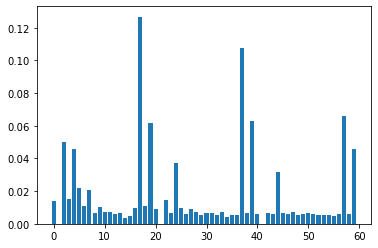

In [15]:
# get importance
unimportant_columns =[]

importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v*100 > 2:
        print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
    if v*100 <= 2:
        unimportant_columns.append(x_columns[i])
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [62]:
print(unimportant_columns)

['melspectrogram_6dB', 'melspectrogram_min_6dB', 'melspectrogram_sum_6dB', 'mfcc_6dB', 'spectral_centroid_6dB', 'spectral_bandwidth_6dB', 'spectral_contrast_6dB', 'spectral_flatness _6dB', 'spectral_rolloff_6dB', 'zero_crossing_rate_6dB', 'mean harm_6dB', 'mean perc_6dB', 'max harm_6dB', 'min harm_6dB', 'melspectrogram_0dB', 'melspectrogram_min_0dB', 'melspectrogram_max_0dB', 'melspectrogram_sum_0dB', 'melspectrogram_std_0dB', 'mfcc_0dB', 'rms_0dB', 'spectral_centroid_0dB', 'spectral_bandwidth_0dB', 'spectral_contrast_0dB', 'spectral_flatness _0dB', 'spectral_rolloff_0dB', 'zero_crossing_rate_0dB', 'mean harm_0dB', 'mean perc_0dB', 'max harm_0dB', 'min harm_0dB', 'melspectrogram_-6dB', 'melspectrogram_min_-6dB', 'melspectrogram_max_-6dB', 'melspectrogram_sum_-6dB', 'melspectrogram_std_-6dB', 'mfcc_-6dB', 'rms_-6dB', 'spectral_centroid_-6dB', 'spectral_bandwidth_-6dB', 'spectral_contrast_-6dB', 'spectral_flatness _-6dB', 'spectral_rolloff_-6dB', 'zero_crossing_rate_-6dB', 'mean harm_-6d

In [63]:
y=valve['normal(0)/abnormal(1)'].values
x=valve.drop(columns=unimportant_columns, axis=1)

In [64]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [65]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[745   0]
 [  0  89]]
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       745
           1       1.00      1.00      1.00        89

    accuracy                           1.00       834
   macro avg       1.00      1.00      1.00       834
weighted avg       1.00      1.00      1.00       834

accuracy score
1.0


In [53]:
import pandas as pd
from functools import reduce

In [54]:
df_min6dB = pd.read_csv("Librosa_features_valve_-6dB.csv")
df_0dB = pd.read_csv("Librosa_features_valve_0dB.csv")
df_6dB = pd.read_csv("Librosa_features_valve_6dB.csv")

In [55]:
def merge_pd(machine):
    df_6dB=pd.read_csv(f'Librosa_features_{machine}_6dB.csv')
    df_0dB=pd.read_csv(f'Librosa_features_{machine}_0dB.csv')
    df_min6dB=pd.read_csv(f'Librosa_features_{machine}_-6dB.csv')
    df_6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_0dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_min6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

    df_6dB.columns = [str(col) + '_6dB' for col in df_6dB.columns]
    df_0dB.columns = [str(col) + '_0dB' for col in df_0dB.columns]
    df_min6dB.columns = [str(col) + '_-6dB' for col in df_min6dB.columns]
    data_frames = [df_6dB, df_0dB, df_min6dB]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), data_frames)
    
    return df_merged

valve=merge_pd('valve')

valve.drop(columns=['normal(0)/abnormal(1)_6dB','normal(0)/abnormal(1)_0dB'],axis=1,inplace=True)
valve.rename(columns={'normal(0)/abnormal(1)_-6dB': 'normal(0)/abnormal(1)'}, inplace=True)

In [56]:
y=valve['normal(0)/abnormal(1)'].values
x=valve.drop(columns=['normal(0)/abnormal(1)'], axis=1)

In [67]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# Lets split the data into 5 folds.
# We will use this 'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 3336, Test set:834
Fold:2, Train set: 3336, Test set:834
Fold:3, Train set: 3336, Test set:834
Fold:4, Train set: 3336, Test set:834
Fold:5, Train set: 3336, Test set:834


In [ ]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

In [68]:
valve.head()

,melspectrogram_6dB,melspectrogram_min_6dB,melspectrogram_max_6dB,melspectrogram_sum_6dB,melspectrogram_corr_6dB,melspectrogram_std_6dB,mfcc_6dB,rms_6dB,spectral_centroid_6dB,spectral_bandwidth_6dB,...,spectral_flatness _-6dB,spectral_rolloff_-6dB,zero_crossing_rate_-6dB,mean harm_-6dB,mean perc_-6dB,max harm_-6dB,max perc_-6dB,min harm_-6dB,min perc_-6dB,normal(0)/abnormal(1)
0,0.006300,6.218734e-10,0.090277,347.580261,0.523183,0.010437,-15.342528,0.002967,1399.372425,1635.526256,...,0.000629,3566.218188,0.098873,-2.914727e-07,-1.149451e-06,0.024765,0.104119,-0.025627,-0.085298,0
1,0.007236,7.803309e-10,0.087623,399.178070,0.461858,0.009354,-14.877153,0.002920,1765.622412,1767.165689,...,0.000419,2937.083941,0.053674,1.012487e-06,2.031724e-06,0.030395,0.076841,-0.030091,-0.060521,0
2,0.006186,6.056689e-10,0.092516,341.284851,0.494020,0.008715,-16.809891,0.002680,1716.821280,1784.159467,...,0.000424,3644.831866,0.084243,-7.028235e-08,-1.127828e-06,0.028087,0.073661,-0.029678,-0.070317,0
3,0.006994,6.636679e-10,0.097133,385.858826,0.489502,0.009895,-15.353941,0.002953,1466.548926,1585.731245,...,0.000294,2854.123654,0.057706,9.979737e-08,7.113005e-07,0.023710,0.068743,-0.026346,-0.062864,0
4,0.005965,5.532336e-10,0.119931,329.072296,0.520290,0.010416,-15.100811,0.002925,1267.393978,1510.835471,...,0.000318,3178.745434,0.074161,-1.004464e-06,-1.443682e-06,0.029470,0.086958,-0.028582,-0.074641,0


array([[<AxesSubplot:xlabel='melspectrogram_6dB', ylabel='melspectrogram_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_min_6dB', ylabel='melspectrogram_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_max_6dB', ylabel='melspectrogram_6dB'>,
        ...,
        <AxesSubplot:xlabel='min harm_-6dB', ylabel='melspectrogram_6dB'>,
        <AxesSubplot:xlabel='min perc_-6dB', ylabel='melspectrogram_6dB'>,
        <AxesSubplot:xlabel='normal(0)/abnormal(1)', ylabel='melspectrogram_6dB'>],
       [<AxesSubplot:xlabel='melspectrogram_6dB', ylabel='melspectrogram_min_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_min_6dB', ylabel='melspectrogram_min_6dB'>,
        <AxesSubplot:xlabel='melspectrogram_max_6dB', ylabel='melspectrogram_min_6dB'>,
        ...,
        <AxesSubplot:xlabel='min harm_-6dB', ylabel='melspectrogram_min_6dB'>,
        <AxesSubplot:xlabel='min perc_-6dB', ylabel='melspectrogram_min_6dB'>,
        <AxesSubplot:xlabel='normal(0)/abnormal(1)', ylabel='melspectrogra

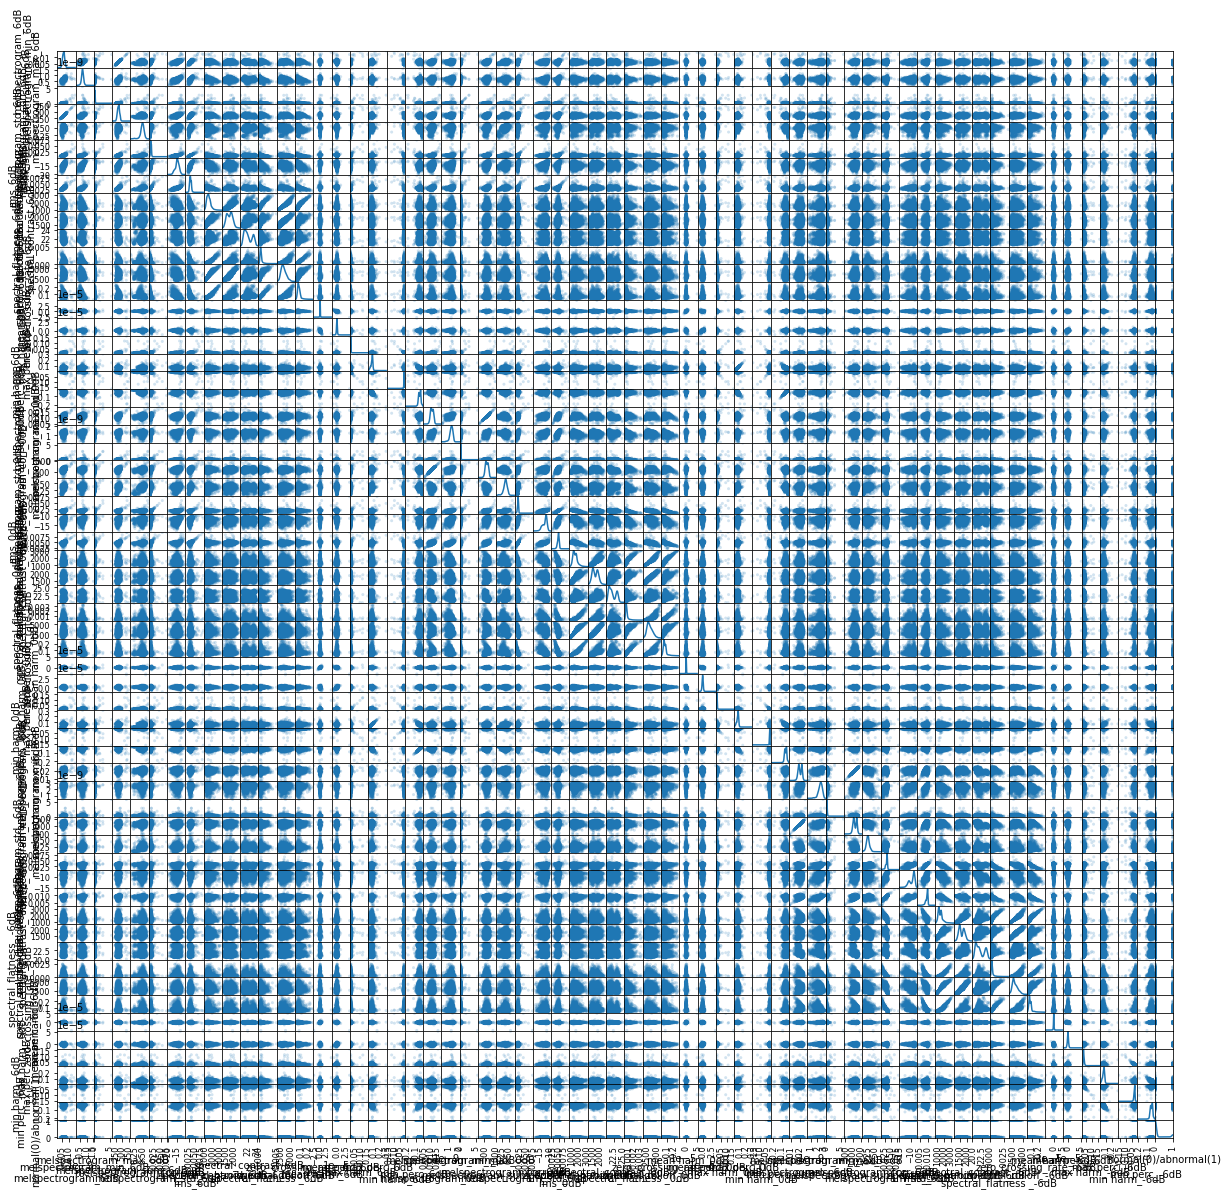

In [72]:
pd.plotting.scatter_matrix(valve, alpha=0.2, figsize=(20,20), diagonal='kde')

In [71]:
valve.corr().style.background_gradient(cmap="coolwarm")

,melspectrogram_6dB,melspectrogram_min_6dB,melspectrogram_max_6dB,melspectrogram_sum_6dB,melspectrogram_corr_6dB,melspectrogram_std_6dB,mfcc_6dB,rms_6dB,spectral_centroid_6dB,spectral_bandwidth_6dB,spectral_contrast_6dB,spectral_flatness _6dB,spectral_rolloff_6dB,zero_crossing_rate_6dB,mean harm_6dB,mean perc_6dB,max harm_6dB,max perc_6dB,min harm_6dB,min perc_6dB,melspectrogram_0dB,melspectrogram_min_0dB,melspectrogram_max_0dB,melspectrogram_sum_0dB,melspectrogram_corr_0dB,melspectrogram_std_0dB,mfcc_0dB,rms_0dB,spectral_centroid_0dB,spectral_bandwidth_0dB,spectral_contrast_0dB,spectral_flatness _0dB,spectral_rolloff_0dB,zero_crossing_rate_0dB,mean harm_0dB,mean perc_0dB,max harm_0dB,max perc_0dB,min harm_0dB,min perc_0dB,melspectrogram_-6dB,melspectrogram_min_-6dB,melspectrogram_max_-6dB,melspectrogram_sum_-6dB,melspectrogram_corr_-6dB,melspectrogram_std_-6dB,mfcc_-6dB,rms_-6dB,spectral_centroid_-6dB,spectral_bandwidth_-6dB,spectral_contrast_-6dB,spectral_flatness _-6dB,spectral_rolloff_-6dB,zero_crossing_rate_-6dB,mean harm_-6dB,mean perc_-6dB,max harm_-6dB,max perc_-6dB,min harm_-6dB,min perc_-6dB,normal(0)/abnormal(1)
melspectrogram_6dB,1.000000,0.526698,0.487072,1.000000,0.147619,0.665586,0.609797,0.779086,0.055451,0.071227,-0.351026,-0.009533,0.130435,-0.053673,0.013151,-0.056629,0.335047,0.140473,-0.333215,0.055887,0.346748,0.115888,0.403618,0.346748,0.340501,0.401574,0.212578,0.455582,0.066643,0.151431,0.022393,0.002856,0.101977,-0.006018,0.030256,-0.011731,0.318309,0.125833,-0.317806,0.052358,0.101583,0.050781,0.155743,0.101583,0.197959,0.123687,0.083831,0.157155,0.029405,0.089894,0.010321,0.003551,0.056497,-0.008554,0.002187,0.002628,0.137463,0.043751,-0.127898,0.132214,-0.104899
melspectrogram_min_6dB,0.526698,1.000000,0.174348,0.526698,0.105395,0.458178,0.593021,0.577708,-0.295269,-0.083628,-0.222383,-0.360042,-0.177507,-0.391470,0.016286,-0.101854,0.098402,0.052882,-0.102958,0.156999,0.150120,0.108077,0.110611,0.150120,0.105694,0.200796,0.185810,0.236737,-0.014475,0.066819,0.001365,-0.026547,0.014415,-0.041626,-0.002555,-0.056626,0.106920,0.032219,-0.101907,0.163067,0.029730,0.009028,0.054118,0.029730,0.046399,0.048665,0.054133,0.060541,0.003059,0.034190,0.004804,0.004610,0.009858,0.004323,-0.007571,-0.030560,0.058778,0.006615,-0.041610,0.164743,-0.019197
melspectrogram_max_6dB,0.487072,0.174348,1.000000,0.487072,0.247059,0.817646,0.378502,0.617471,0.006323,0.138759,-0.001020,-0.069980,0.072253,-0.087585,-0.085408,0.127434,0.797894,-0.026214,-0.806185,0.077078,0.273849,0.073772,0.909349,0.273849,0.174483,0.563478,0.178805,0.431514,0.013551,0.081503,-0.002157,-0.017938,0.042342,-0.017930,-0.085312,0.123720,0.674758,-0.040419,-0.676930,0.078320,0.083008,0.028789,0.430537,0.083008,0.070998,0.168889,0.076962,0.146526,-0.004545,0.029081,-0.017055,-0.006830,0.010324,-0.008872,-0.143879,0.149036,0.319252,-0.157587,-0.314966,0.220745,0.021206
melspectrogram_sum_6dB,1.000000,0.526698,0.487072,1.000000,0.147619,0.665586,0.609797,0.779086,0.055451,0.071227,-0.351026,-0.009533,0.130435,-0.053673,0.013151,-0.056629,0.335047,0.140473,-0.333215,0.055887,0.346748,0.115888,0.403618,0.346748,0.340501,0.401574,0.212578,0.455582,0.066643,0.151431,0.022393,0.002856,0.101977,-0.006018,0.030256,-0.011731,0.318309,0.125833,-0.317806,0.052358,0.101583,0.050781,0.155743,0.101583,0.197959,0.123687,0.083831,0.157155,0.029405,0.089894,0.010321,0.003551,0.056497,-0.008554,0.002187,0.002628,0.137463,0.043751,-0.127898,0.132214,-0.104899
melspectrogram_corr_6dB,0.147619,0.105395,0.247059,0.147619,1.000000,0.445966,0.277829,0.462307,-0.171491,0.115531,0.184440,-0.288636,-0.103145,-0.301045,-0.015285,-0.003162,0.151376,0.291761,-0.154980,-0.152168,0.191652,0.059468,0.166343,0.191652,0.507056,0.192342,0.117680,0.258217,0.061123,0.112746,0.033773,0.025874,0.077714,0.011640,-0.018138,-0.024219,0.088757,0.271814,-0.090635,-0.144253,0.076830,0.021041,0.048689,0.076830,0.315870,0.047918,0.047922,0.086728,0.040020,0.057415,0.000283,0.035808,0.044382,0.0

In [16]:
import seaborn as sns

sns.pairplot(valve, hue='normal(0)/abnormal(1)', size=3)

C:\Users\vervo\anaconda3\envs\Codit\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002AD753914C8> (for post_execute):


KeyboardInterrupt: 

In [57]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipeline.steps

[('scaler', StandardScaler()), ('svc', SVC())]

In [78]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(valve.drop(columns=['normal(0)/abnormal(1)'], axis=1),
                                                   valve['normal(0)/abnormal(1)'],
                                                   test_size = 0.2,
                                                   random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3336, 60)
(834, 60)
(3336,)
(834,)


In [79]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

scores

array([0.94011976, 0.93103448, 0.93553223, 0.94002999, 0.93853073])

In [81]:
scores.mean()

0.9370494393521802

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = []
clfs = []
clfs.append(SVC(kernel="linear", C=0.025))
clfs.append(SVC(gamma=2, C=1))
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier(max_depth=5))
clfs.append(RandomForestClassifier(n_estimators = 100, random_state = 42))
clfs.append(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=0))

for classifier in clfs:
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print('confusion matrix', classifier)
    print(confusion_matrix(y_test, y_pred))
    print('classification report')
    print(classification_report(y_test, y_pred))
    print('accuracy score')
    print(accuracy_score(y_test, y_pred))

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores
         
    

In [26]:
from sklearn.model_selection import GridSearchCV
pipeline.set_params(clf= SVC())
pipeline.steps

[('normalizer', StandardScaler()), ('clf', SVC())]

In [27]:
cv_grid = GridSearchCV(pipeline, param_grid = {
    'clf__kernel' : ['linear', 'rbf'],
    'clf__C' : np.linspace(0.1,1.2,12)
})

cv_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
                         'clf__kernel': ['linear', 'rbf']})

In [28]:
cv_grid.best_params_

{'clf__C': 1.2, 'clf__kernel': 'rbf'}

In [29]:
cv_grid.best_estimator_

Pipeline(steps=[('normalizer', StandardScaler()), ('clf', SVC(C=1.2))])

In [30]:
cv_grid.best_score_

0.9336566866267464